# Latency evaluation

In [1]:
RESULT_DIR = "../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo"

In [2]:
import os
import sys
sys.path.append("..")

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.eval.SampleResult import SampleResult

In [3]:
files = os.listdir(RESULT_DIR)
files = [f for f in files if f.endswith("final.json")]

# get ids from the first part of the filename separated by "_"
file_ids = [f.split("_")[0] for f in files]

samples = [SampleResult.load_by_id(RESULT_DIR, file_id) for file_id in file_ids]

/Users/niko/Code/streaming-asr-evaluation/notebooks/../src/eval/SampleResult.py:158: UserWarning: Final MFA file not found: ../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo/mfa/3575-170457-0000/3575-170457-0000.TextGrid
  warnings.warn(f"Final MFA file not found: {final_mfa_path}")
/Users/niko/Code/streaming-asr-evaluation/notebooks/../src/eval/SampleResult.py:158: UserWarning: Final MFA file not found: ../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo/mfa/7127-75947-0000/7127-75947-0000.TextGrid
  warnings.warn(f"Final MFA file not found: {final_mfa_path}")


# Evaluation Parameters

In [95]:
ALIGNMENT_SEQUENCE = "baseline"
TEMPORAL_ALIGNMENT_TOLERANCE = 0.1
ALIGNMENT_WORD_NORMALIZATION = True     # No difference

In [96]:
eval = pd.Series()
eval["num_samples"] = len(samples)
eval["alignment_sequence"] = ALIGNMENT_SEQUENCE
eval["alignment_word_normalization"] = ALIGNMENT_WORD_NORMALIZATION
eval["temporal_alignment_tolerance"] = TEMPORAL_ALIGNMENT_TOLERANCE

In [97]:
for sample in samples:
    try:
        sample.build_alignments(normalize_words=ALIGNMENT_WORD_NORMALIZATION,
                                align_to=ALIGNMENT_SEQUENCE,
                                temporal_tolerance=TEMPORAL_ALIGNMENT_TOLERANCE)
    except Exception as e:
        print(f"Error processing sample {sample.sample_id}: {e}")
        continue

In [98]:
samples_df = pd.DataFrame([{
    "id": sample.sample_id,
    "sample": sample,
    "word_count_final": len(sample.final),
    "word_count_baseline": len(sample.baseline),
    "word_count_transcript": len(sample.transcript),
} for sample in samples])
samples_df

,id,sample,word_count_final,word_count_baseline,word_count_transcript
0,7127-75946-0000,<src.eval.SampleResult.SampleResult object at ...,496,605,604
1,908-31957-0000,<src.eval.SampleResult.SampleResult object at ...,450,466,472
2,5142-33396-0000,<src.eval.SampleResult.SampleResult object at ...,799,921,941
3,2094-142345-0000,<src.eval.SampleResult.SampleResult object at ...,1055,1082,1159
4,121-123852-0000,<src.eval.SampleResult.SampleResult object at ...,122,116,115
...,...,...,...,...,...
78,908-157963-0000,<src.eval.SampleResult.SampleResult object at ...,513,604,621
79,3570-5694-0000,<src.eval.SampleResult.SampleResult object at ...,521,616,614
80,7021-85628-0000,<src.eval.SampleResult.SampleResult object at ...,470,475,477
81,4992-41806-0000,<src.eval.SampleResult.SampleResult object at ...,362,368,384


In [99]:
def total_partial_words(sample: SampleResult) -> int:
    partial_words = [len(partial.result) for partial in sample.partials]
    return sum(partial_words)

def unaligned_partial_words(sample: SampleResult) -> int:
    unalignments = [len(alignements.unalignments) for alignements in sample.alignments]
    return sum(unalignments)

In [100]:
samples_df["unaligned_partial_count"] = samples_df["sample"].apply(unaligned_partial_words)
samples_df["partial_count"] = samples_df["sample"].apply(total_partial_words)

eval["total_partial_count"] = samples_df["partial_count"].sum().item()
eval["unaligned_partial_count"] = samples_df["unaligned_partial_count"].sum().item()

## Word first correct

The word first correct (wfc) is defined as the first correct occurence of a word.

In [101]:
wfc = [s.word_first_corrects() for s in samples]

In [102]:
total_wfc = np.concat(wfc)
wfc_latency = np.array([r["latency"] for r in total_wfc if r is not None])
none_wfc_count = len(total_wfc) - len(wfc_latency)
print("None values in wfc: ", none_wfc_count, f"({none_wfc_count / len(total_wfc) * 100:.2f}%)")
eval["wfc_none_count"] = none_wfc_count

None values in wfc:  186 (0.39%)


In [103]:
print("Min:", np.min(wfc_latency))
print("Max:", np.max(wfc_latency))
print("Mean:", np.mean(wfc_latency))
print("Median:", np.median(wfc_latency))
print("Std:", np.std(wfc_latency))
print("P95:", np.percentile(wfc_latency, 95))
print("P99:", np.percentile(wfc_latency, 99))

eval["wfc_latency_count"] = len(wfc_latency)
eval["wfc_latency_mean"] = np.mean(wfc_latency).item()
eval["wfc_latency_std"] = np.std(wfc_latency).item()
eval["wfc_latency_median"] = np.median(wfc_latency).item()

Min: 0.38317274600267415
Max: 80.20766255706549
Mean: 2.6468917082347514
Median: 2.1636991819366784
Std: 1.756360159357369
P95: 5.892275398805738
P99: 9.816909682153915


In [104]:
### DEBUG

for i, s_el in enumerate(wfc):
    for el in s_el:
        if el and el["latency"] > 30:
            sample_id = samples[i].sample_id
            print(f"Sample {sample_id} with huge latency {el}")

Sample 7127-75947-0000 with huge latency {'timestep': 301, 'observation_time': 223.21895988844335, 'latency': 49.27895988844335}
Sample 5639-40744-0000 with huge latency {'timestep': 97, 'observation_time': 138.5076625570655, 'latency': 80.20766255706549}
Sample 5639-40744-0000 with huge latency {'timestep': 97, 'observation_time': 138.5076625570655, 'latency': 79.80766255706548}
Sample 5639-40744-0000 with huge latency {'timestep': 92, 'observation_time': 121.00884376838803, 'latency': 62.12884376838803}
Sample 5639-40744-0000 with huge latency {'timestep': 92, 'observation_time': 121.00884376838803, 'latency': 61.36884376838803}


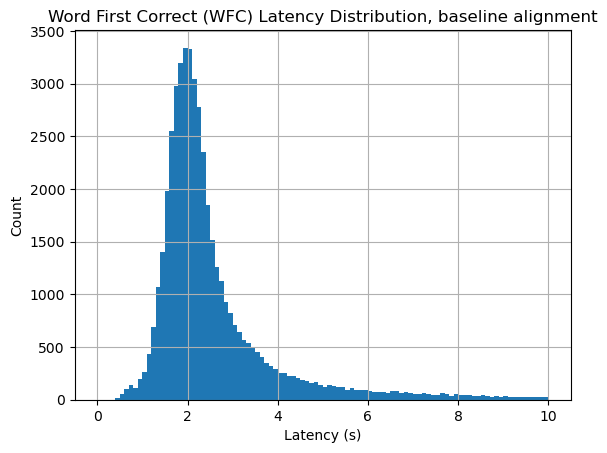

In [105]:
plt.hist(wfc_latency,
         bins=100,
         range=(0, math.ceil(np.percentile(wfc_latency, 99).item())),
         )
plt.xlabel("Latency (s)")
plt.ylabel("Count")
plt.title(f"Word First Correct (WFC) Latency Distribution, {ALIGNMENT_SEQUENCE} alignment")
plt.grid()

## Word first final

The word first final (wff) is defined as the first occurence after which a word will never change to a different prediction.

In [106]:
wff = [s.word_first_finals() for s in samples]

In [107]:
total_wff = np.concat(wff)
wff_latency = np.array([r["latency"] for r in total_wff if r is not None])
none_wff_count = len(total_wff) - len(wff_latency)
print("None values in wff: ", none_wff_count, f"({none_wff_count / len(total_wff) * 100:.2f}%)")
eval["wff_none_count"] = none_wff_count

None values in wff:  186 (0.39%)


In [108]:
print("Min:", np.min(wff_latency))
print("Max:", np.max(wff_latency))
print("Mean:", np.mean(wff_latency))
print("Median:", np.median(wff_latency))
print("Std:", np.std(wff_latency))
print("P95:", np.percentile(wff_latency, 95))
print("P99:", np.percentile(wff_latency, 99))

eval["wff_latency_count"] = len(wff_latency)
eval["wff_latency_mean"] = np.mean(wff_latency).item()
eval["wff_latency_std"] = np.std(wff_latency).item()
eval["wff_latency_median"] = np.median(wff_latency).item()

Min: 0.38317274600267415
Max: 143.80088769987225
Mean: 8.756123575876243
Median: 6.315489719659091
Std: 9.659970380810906
P95: 18.998294770952295
P99: 30.70654663401173


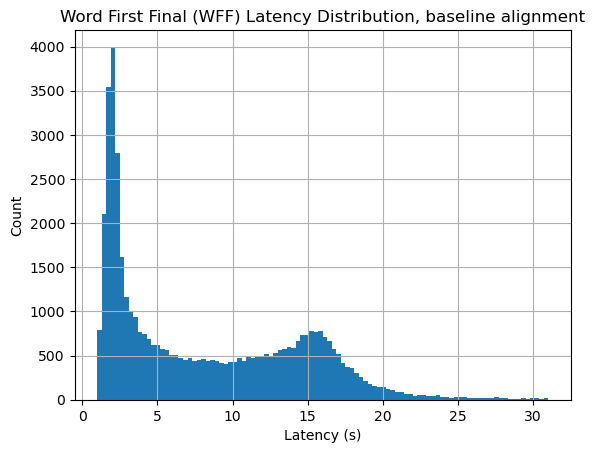

In [109]:
plt.hist(wff_latency, bins=100, range=(math.floor(np.percentile(wff_latency, 1)), math.ceil(np.percentile(wff_latency, 99).item())))
plt.xlabel("Latency (s)")
plt.ylabel("Count")
plt.title(f"Word First Final (WFF) Latency Distribution, {ALIGNMENT_SEQUENCE} alignment")
plt.grid()

In [110]:
eval

num_samples                           83
alignment_sequence              baseline
alignment_word_normalization        True
temporal_alignment_tolerance         0.1
total_partial_count               964777
unaligned_partial_count             2510
wfc_none_count                       186
wfc_latency_count                  47672
wfc_latency_mean                2.646892
wfc_latency_std                  1.75636
wfc_latency_median              2.163699
wff_none_count                       186
wff_latency_count                  47672
wff_latency_mean                8.756124
wff_latency_std                  9.65997
wff_latency_median               6.31549
dtype: object